In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable


import numpy as np
import pandas as pd
import netCDF4 as nc
from glob import glob
import datetime as dtm
import xarray as xr
import os

import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from shapely.geometry.polygon import Polygon
import seaborn as sns

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

MAIN_DIR = '/projects/0/ctdas/awoude/Ritten/transport_results/'
SAVE_DIR = '/gpfs/home5/awoude/Ritten/EKF/Results/'
# continents_file = '/gpfs/home5/awoude/Ritten/EKF/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
continents_file = '/gpfs/home5/awoude/Ritten/EKF/Transcom_regions/transcom_regions.shp'
# '/projects/0/ctdas/ingrid/gcp2021_era5_sib4_insitu_newff_merged_output_fwd_corrected/'

def get_cte(run, sites=[], files=[]):
    """Get CTE mole fractions"""
    dfs = []
    path = MAIN_DIR + run + '/'
    if len(sites)!=0:
        files = sorted(glob(path + '*.nc'))
        print(files)
        req_sites = [s.lower() for s in sites]
        print(req_sites)
        filtered_files = [file for file in files if any(site in file.split('/')[-1] for site in req_sites)]
    elif len(files)!=0:
        filtered_files = [path+f for f in files]
    else:
        raise RuntimeError(f"No sites or files specified for analysing run {run}")
    for f in filtered_files:
        print(f)
        with nc.Dataset(f) as ds:
            #print(ds.variables)
            name = ds.site_code
            # if not name in sites: continue
            df = pd.DataFrame()
            
            times = np.array(nc.num2date(ds['time'][:], ds['time'].units))
            times = np.array([dtm.datetime(t.year, t.month, t.day, t.hour) for t in times])
            inds = np.where((times >= dtm.datetime(2019, 1, 5, 0)) & (times <= dtm.datetime(2021, 1, 1, 0)))[0]
            times = times[inds]
            observed = ds['value'][inds] * 1e6

            if len(inds)==0:
                print(f'-----ERROR!!! site {name} has an empty dataset!!!!!')
                continue

#             if run == 'optimized':
#                 simulated = ds['modelsamplesensemble'][inds, 1:].sum(axis=1) * 1e6 + ds['modelsamplesmean'][inds] * 1e6 
#             else: 
#                 simulated = (ds['modelsamplesensemble'][inds, 1:].sum(axis=1) + ds['modelsamplesmean'][inds]) * 1e6
            simulated = (ds['modelsamplesensemble'][inds, 1:].sum(axis=1) + ds['modelsamplesmean'][inds]) * 1e6
            #print(f"run {run} has the summed change in consentrations: {ds['modelsamplesensemble'][-5, :]}")
            stddev = ds['modelsamplesstandarddeviation'][inds]
            inds = np.where(simulated.mask==False)[0]
            times = times[inds]
            simulated = simulated[inds]#.reshape(-1, 5)
            
            #print(times)
            observed = observed[inds]
            # height = ds['intake_height'][inds] --> Is this really needed?
            df['time'] = times
            df['stddev'] = stddev[inds]
            df['simulated'] = simulated
            df['observed'] = observed
            df['name'] = name
            df['lon'] = ds.site_longitude
            df['lat'] = ds.site_latitude
            # df = df[(df.time >= dtm.datetime(2019, 1, 5, 0)) & (df.time < dtm.datetime(2020, 12, 31, 0))] # filtering out all measurements that happened before the first saterday of 2019
            #gdf = gpd.GeoDataFrame(df, geometry=Point(ds.site_longitude,ds.site_latitude))

#             df['height'] = height # Kan je toevoegen, hoeft voor nu niet denk ik
            dfs.append(df)
    df = pd.concat(dfs)
    df.index = [df['time'], df['name']]
    df = df.drop(['time', 'name'], axis=1)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf = gdf.drop(['lon', 'lat'], axis=1)
    return gdf

def get_stddev_obs(run, sites=[], files=[]):
    """Get CTE mole fractions"""
    dfs = []
    path = MAIN_DIR + run + '/'
    if len(sites)!=0:
        files = sorted(glob(path + '*.nc'))
        #print(files)
        req_sites = [s.lower() for s in sites]
        #print(req_sites)
        filtered_files = [file for file in files if any(site in file.split('/')[-1] for site in req_sites)]
    elif len(files)!=0:
        filtered_files = [path+f for f in files]
    else:
        raise RuntimeError(f"No sites or files specified for analysing run {run}")
    for f in filtered_files:
        #print(f)
        with nc.Dataset(f) as ds:
            name = ds.site_code
            # if not name in sites: continue
            df = pd.DataFrame()
            
            times = np.array(nc.num2date(ds['time'][:], ds['time'].units))
            times = np.array([dtm.datetime(t.year, t.month, t.day, t.hour) for t in times])
            inds = np.where((times >= dtm.datetime(2000, 1, 1, 0)) & (times < dtm.datetime(2021, 1, 1, 0)))[0]
            

            # height = ds['intake_height'][inds] --> Is this really needed?
            df['time'] = times[inds]
            df['stddev'] = ds['modelsamplesstandarddeviation'][inds]
            df['name'] = name
            # df = df[(df.time >= dtm.datetime(2019, 1, 5, 0)) & (df.time < dtm.datetime(2020, 12, 31, 0))] # filtering out all measurements that happened before the first saterday of 2019
            #gdf = gpd.GeoDataFrame(df, geometry=Point(ds.site_longitude,ds.site_latitude))

#             df['height'] = height # Kan je toevoegen, hoeft voor nu niet denk ik
            dfs.append(df)
    df = pd.concat(dfs)
    df.index = [df['time'], df['name']]
    df = df.drop(['time', 'name'], axis=1)
    return df


In [2]:
with xr.open_dataset('/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_abt_surface-insitu_6_allvalid.nc') as ds:
    obs = ds
    
obs

<xarray.Dataset>
Dimensions:                                 (obs: 37911,
                                             calendar_components: 6,
                                             dim_concerns: 5, mip_nmodels: 17,
                                             nmembers: 5)
Dimensions without coordinates: obs, calendar_components, dim_concerns,
                                mip_nmodels, nmembers
Data variables: (12/39)
    time                                    (obs) datetime64[ns] ...
    start_time                              (obs) datetime64[ns] ...
    midpoint_time                           (obs) datetime64[ns] ...
    datetime                                (obs) |S100 ...
    time_decimal                            (obs) float64 ...
    time_components                         (obs, calendar_components) float64 ...
    ...                                      ...
    modelsamplesmean                        (obs) float32 ...
    modelsamplesmean_forecast               (obs) float32 ...
    modelsamplesstandarddeviation           (obs) float32 ...
    modelsamplesstandarddeviation_forecast  (obs) float32 ...
    modelsamplesensemble                    (obs, nmembers) float32 ...
    modelsamplesensemble_forecast           (obs, nmembers) float32 ...
Attributes: (12/87)
    site_code:                                    ABT
    site_name:                                    Abbotsford, British Columbia
    site_country:                                 Canada
    site_country_flag:                            CANA0001.GIF
    site_latitude:                                49.0114
    site_longitude:                               -122.3353
    ...                                           ...
    Caution:                                      ===========================...
    History:                                      \nOriginal observation file...
    CTDAS_info:                                   Simulated values added from...
    CTDAS_startdate:                              2019-01-05
    CTDAS_enddate:                                2021-02-01
    original_file:                                /mnt/beegfs/user/gkoren/ctd...

In [4]:
df_GCP = get_cte('optimized', sites={'AZR', 'ESP'})
df_CTE = get_cte('smoothed', sites={'AZR', 'ESP'})
df_Monthly = get_cte('monthly', sites={'AZR', 'ESP'})
df_prior = get_cte('prior', sites={'AZR', 'ESP'})

['/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_abt_surface-insitu_6_allvalid.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_act_aircraft-insitu_428_allvalid-b200.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_act_aircraft-insitu_428_allvalid-c130.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_act_aircraft-pfp_1_allvalid-b200.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_act_aircraft-pfp_1_allvalid-c130.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_alt_surface-flask_1_representative-NRT.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_alt_surface-flask_1_representative.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_alt_surface-flask_2_representative.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_alt_surface-flask_426_representative.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/

['/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_abt_surface-insitu_6_allvalid.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_act_aircraft-insitu_428_allvalid-b200.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_act_aircraft-insitu_428_allvalid-c130.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_act_aircraft-pfp_1_allvalid-b200.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_act_aircraft-pfp_1_allvalid-c130.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_alt_surface-flask_1_representative-NRT.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_alt_surface-flask_1_representative.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_alt_surface-flask_2_representative.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_alt_surface-flask_426_representative.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/

/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_esp_aircraft-pfp_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_esp_surface-insitu_6_allvalid.nc
['/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_abt_surface-insitu_6_allvalid.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_act_aircraft-insitu_428_allvalid-b200.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_act_aircraft-insitu_428_allvalid-c130.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_act_aircraft-pfp_1_allvalid-b200.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_act_aircraft-pfp_1_allvalid-c130.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_alt_surface-flask_1_representative-NRT.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_alt_surface-flask_1_representative.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_alt_surface-flask_2_repr

/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_esp_aircraft-pfp_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_esp_surface-insitu_6_allvalid.nc
['/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_abt_surface-insitu_6_allvalid.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_act_aircraft-insitu_428_allvalid-b200.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_act_aircraft-insitu_428_allvalid-c130.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_act_aircraft-pfp_1_allvalid-b200.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_act_aircraft-pfp_1_allvalid-c130.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_alt_surface-flask_1_representative-NRT.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_alt_surface-flask_1_representative.nc', '/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_alt_surface-flask_2_representative.nc', '/

/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_esp_surface-insitu_6_allvalid.nc


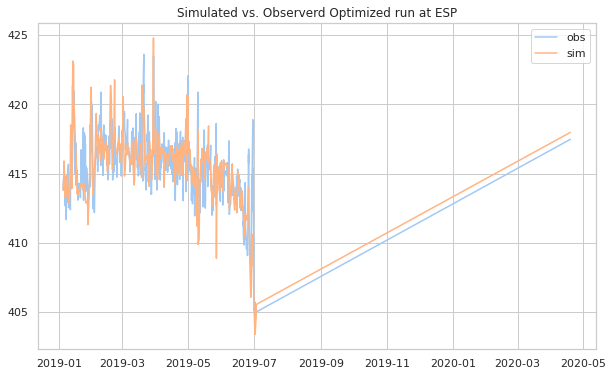

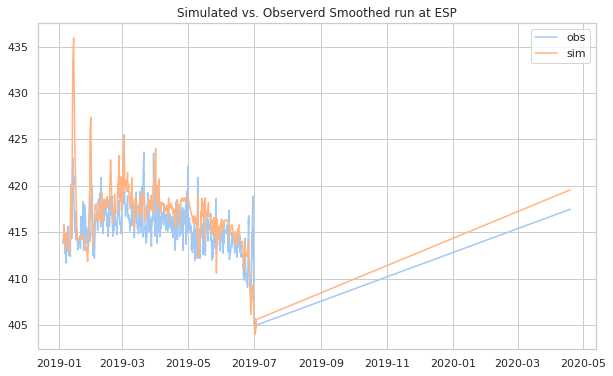

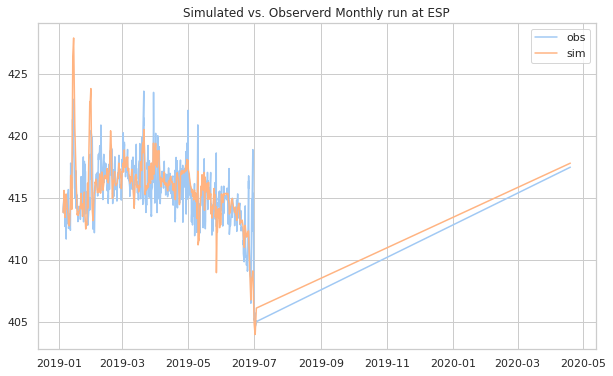

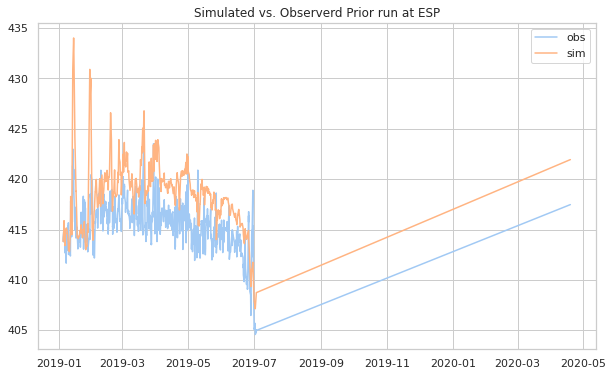

In [6]:
# plt.plot(df.sort_index(level=0).xs('SPO', level=1)['observed'])
# plt.show()
plt.plot(df_GCP.sort_index(level=0).xs('ESP', level=1)['observed'], label='obs')
plt.plot(df_GCP.sort_index(level=0).xs('ESP', level=1)['simulated'], label='sim')
plt.title('Simulated vs. Observerd Optimized run at ESP')
plt.legend()
plt.show()

plt.plot(df_CTE.sort_index(level=0).xs('ESP', level=1)['observed'], label='obs')
plt.plot(df_CTE.sort_index(level=0).xs('ESP', level=1)['simulated'], label='sim')
plt.title('Simulated vs. Observerd Smoothed run at ESP')
plt.legend()
plt.show()

plt.plot(df_Monthly.sort_index(level=0).xs('ESP', level=1)['observed'], label='obs')
plt.plot(df_Monthly.sort_index(level=0).xs('ESP', level=1)['simulated'], label='sim')
plt.title('Simulated vs. Observerd Monthly run at ESP')
plt.legend()
plt.show()

plt.plot(df_prior.sort_index(level=0).xs('ESP', level=1)['observed'], label='obs')
plt.plot(df_prior.sort_index(level=0).xs('ESP', level=1)['simulated'], label='sim')
plt.title('Simulated vs. Observerd Prior run at ESP')
plt.legend()
plt.show()

In [74]:
print(df2.iloc[2])
df2.index.difference(df.index)

NameError: name 'df2' is not defined

In [178]:
len(df)
shp_path

'/gpfs/home5/awoude/Ritten/EKF/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'

In [7]:
continents_file = '/gpfs/home5/awoude/Ritten/EKF/Transcom_regions/transcom_regions.shp'

sf = gpd.read_file(continents_file)
print(sf)
# continents = sf[['CONTINENT', 'geometry']].dissolve(by='CONTINENT')
# print(continents)

    gridcode  Shape_Leng  Shape_Area                transcom_n  \
0          1       856.0      1865.0     North American Boreal   
1          2       306.0      1213.0  North American Temperate   
2          3       260.0       787.0   South American Tropical   
3          4       244.0       850.0  South American Temperate   
4          5       230.0      1819.0           Northern Africa   
5          6       190.0       867.0           Southern Africa   
6          7       520.0      2396.0            Eurasia Boreal   
7          8       476.0      2631.0         Eurasia Temperate   
8          9       556.0       542.0             Tropical Asia   
9         10       242.0       735.0                 Australia   
10        11       428.0      1585.0                    Europe   
11        12       768.0      4664.0   North Pacific Temperate   
12        13       472.0      2584.0     West Pacific Tropical   
13        14       264.0      2862.0     East Pacific Tropical   
14        

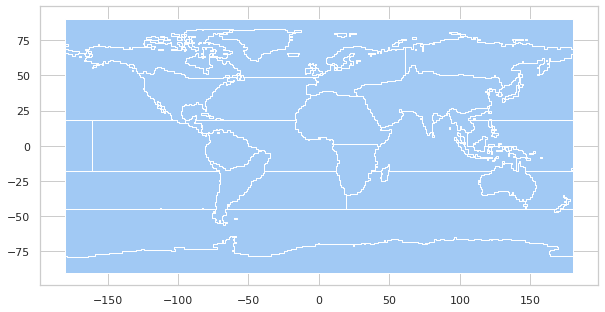

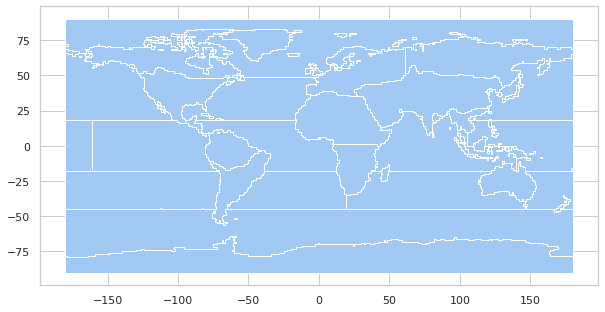

gridcode  Shape_Leng  Shape_Area                transcom_n  \
0          1       856.0      1865.0     North American Boreal   
1          2       306.0      1213.0  North American Temperate   
2          3       260.0       787.0   South American Tropical   
3          4       244.0       850.0  South American Temperate   
4          5       230.0      1819.0           Northern Africa   
5          6       190.0       867.0           Southern Africa   
6          7       520.0      2396.0            Eurasia Boreal   
7          8       476.0      2631.0         Eurasia Temperate   
8          9       556.0       542.0             Tropical Asia   
9         10       242.0       735.0                 Australia   
10        11       428.0      1585.0                    Europe   
11        12       768.0      4664.0   North Pacific Temperate   
12        13       472.0      2584.0     West Pacific Tropical   
13        14       264.0      2862.0     East Pacific Tropical   
14        15       462.0      3706.0   South Pacific Temperate   
15        16      1940.0      7563.0            Northern Ocean   
16        17       344.0      2179.0  North Atlantic Temperate   
17        18       320.0      1994.0         Atlantic Tropical   
18        19       224.0      1864.0  South Atlantic Temperate   
19        20       982.0      9525.0            Southern Ocean   
20        21       626.0      2578.0           Indian Tropical   
21        22       366.0      2667.0    South Indian Temperate   
22        23      1186.0      7324.0             Not optimized   

                                             geometry  
0   MULTIPOLYGON (((-160.00000 56.00000, -160.0000...  
1   MULTIPOLYGON (((-110.00000 24.00000, -109.0000...  
2   MULTIPOLYGON (((-83.00000 9.00000, -80.00000 9...  
3   MULTIPOLYGON (((-58.00000 -52.00000, -60.00000...  
4   POLYGON ((42.00000 0.00000, 41.00000 0.00000, ...  
5   MULTIPOLYGON (((49.00000 -18.00000, 49.00000 -...  
6   MULTIPOLYGON (((156.00000 51.00000, 156.00000 ...  
7   MULTIPOLYGON (((80.00000 10.00000, 81.00000 10...  
8   MULTIPOLYGON (((180.00000 -17.00000, 179.00000...  
9   MULTIPOLYGON (((147.00000 -43.00000, 147.00000...  
10  MULTIPOLYGON (((-5.00000 55.00000, -5.00000 54...  
11  MULTIPOLYGON (((-112.00000 28.00000, -113.0000...  
12  MULTIPOLYGON (((124.00000 11.00000, 123.00000 ...  
13  POLYGON ((-71.00000 -18.00000, -161.00000 -18....  
14  MULTIPOLYGON (((-71.00000 -18.00000, -71.00000...  
15  MULTIPOLYGON (((-64.00000 49.00000, -67.00000 ...  
16  POLYGON ((-16.00000 18.00000, -68.00000 18.000...  
17  MULTIPOLYGON (((-71.00000 9.00000, -72.00000 9...  
18  POLYGON ((19.00000 -45.00000, -65.00000 -45.00...  
19  MULTIPOLYGON (((-70.00000 -54.00000, -71.00000...  
20  MULTIPOLYGON (((121.00000 -4.00000, 120.00000 ...  
21  MULTIPOLYGON (((137.00000 -34.00000, 137.00000...  
22  MULTIPOLYGON (((-68.00000 -68.00000, -69.00000...

In [8]:
sf = gpd.read_file(continents_file)
sf.plot()
plt.show()
continents = sf[['transcom_n', 'geometry']].dissolve(by='transcom_n')
continents.plot()
plt.show()
sf

In [75]:
points = np.array([[-90, 45], [25, 0], [90, 45]])

for i in continents.geometry:
    point = Point(points[0]) # create point
    print(point.within(i))

False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [105]:

with xr.open_dataset(files[0]) as ds:
    print(ds.longitude)

<xarray.DataArray 'longitude' (obs: 37911)>
array([-122.3353, -122.3353, -122.3353, ..., -122.3353, -122.3353, -122.3353],
      dtype=float32)
Dimensions without coordinates: obs
Attributes:
    standard_name:  longitude
    long_name:      sample_longitude_in_decimal_degrees
    units:          degrees_east
    comment:        Longitude at which air sample was collected using a range...


['lut', 'smr', 'pal', 'mhd']
/projects/0/ctdas/awoude/Ritten/transport_results/CTE2018/co2_lut_surface-insitu_442_allvalid-60magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/CTE2018/co2_lut_surface-insitu_442_allvalid-60magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/CTE2018/co2_mhd_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/CTE2018/co2_mhd_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/CTE2018/co2_pal_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/CTE2018/co2_pal_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/CTE2018/co2_pal_surface-insitu_442_allvalid-12magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/CTE2018/co2_pal_surface-insitu_442_allvalid-12magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/CTE2018/co2_smr_surface-insitu_442_allvalid-125magl-NRT.nc
/projects/0/ctdas/awoude/Ritte

<AxesSubplot:>

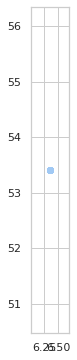

In [77]:
# Selecteer de sites die je wil zien. Voor nu een kleine selectie gemaakt.
sites = {'LUT', 'SMR', 'PAL', 'MHD'}
# Hier gebeurt het uiteindelijk
%time df = get_cte('smoothed', sites=sites)
# Even een plotje maken om te checken:
df.xs('LUT', level=1).plot()

In [78]:
df.xs('LUT', level=1)

simulated    observed                  geometry
time                                                                 
2020-01-01 11:00:00  438.667145  436.071991  POINT (6.35290 53.40370)
2020-01-01 12:00:00  438.396484  439.380005  POINT (6.35290 53.40370)
2020-01-01 13:00:00  438.001068  441.542023  POINT (6.35290 53.40370)
2020-01-01 14:00:00  438.640167  440.337006  POINT (6.35290 53.40370)
2020-01-02 11:00:00  449.969452  434.755981  POINT (6.35290 53.40370)
...                         ...         ...                       ...
2019-12-30 14:00:00  439.985992  444.681000  POINT (6.35290 53.40370)
2019-12-31 11:00:00  418.384491  415.712006  POINT (6.35290 53.40370)
2019-12-31 12:00:00  418.377869  415.782013  POINT (6.35290 53.40370)
2019-12-31 13:00:00  418.386078  415.797974  POINT (6.35290 53.40370)
2019-12-31 14:00:00  418.394623  415.812988  POINT (6.35290 53.40370)

[2651 rows x 3 columns]

In [9]:
def get_error(targets, predictions):
    """Calculate the difference between targets and predictions"""
    return targets - predictions
def get_mse(targets, predictions):
    """Mean Square Error"""
    return (get_error(targets, predictions) ** 2).mean()
def get_rmse(targets, predictions):
    """Root mean square error"""
    return np.sqrt(get_mse(targets, predictions))
def get_index_of_agreement(targets, predictions):
    """Calculate the index of agreement
    Willmott (1981)
    the ratio of the mean square error and the potential error."""
    mse = get_mse(targets, predictions)
    t_mean = targets.mean()
    err_pot = np.mean((np.abs(predictions - t_mean) + np.abs(targets - t_mean))**2)
    return 1 - (mse / err_pot)
def get_correlation(targets, predictions):
    """Calculate the correlation coefficient"""
    return np.corrcoef(targets, predictions)[0,1]
def get_ame(targets, predictions):
    """Absolute maximum error"""
    return np.abs(get_error(targets, predictions)).max()
def get_mae(targets, predictions):
    """Mean absolute error"""
    return np.abs(get_error(targets, predictions)).mean()
def get_me(targets, predictions):
    """Mean error"""
    return (get_error(targets, predictions)).mean()
def get_bias(targets, predictions):
    """Calculate the bias"""
    error = np.array(predictions) - np.array(targets)
    bias = np.mean(error)
    return bias
def get_abs_bias(targets, predictions):
    """Calculate the bias"""
    error = np.abs(np.array(predictions) - np.array(targets))
    bias = np.mean(error)
    return bias
def get_taylor(targets, predictions):
    """Calculate the taylor skill score (2001)"""
    r = get_correlation(targets, predictions)
    r0 = 0.97
    sf = np.std(targets) / np.std(predictions)
    
    s = (4*(1 + r)**4) / ((sf + 1/sf)**2 * (1 + r0)**4)
    return s

In [10]:
files_smoothed = set([os.path.basename(x) for x in glob(MAIN_DIR + 'smoothed/' + '*.nc')])
sites_smoothed = set([x.split('_')[1] for x in files_smoothed])

files_optimized = set([os.path.basename(x) for x in glob(MAIN_DIR + 'optimized/' + '*.nc')])
sites_optimized = set([x.split('_')[1] for x in files_optimized])

files_monthly = set([os.path.basename(x) for x in glob(MAIN_DIR + 'monthly/' + '*.nc')])
sites_monthly = set([x.split('_')[1] for x in files_monthly])

files_prior = set([os.path.basename(x) for x in glob(MAIN_DIR + 'prior/' + '*.nc')])
sites_prior = set([x.split('_')[1] for x in files_prior])

# print(f'Intersection sites smoothed & optimized: {sites_smoothed.intersection(sites_optimized)}\n')
# print(f'Intersection sites monthly & optimized: {sites_monthly.intersection(sites_optimized)}\n')
# print(f'Intersection sites smoothed & monthly: {sites_smoothed.intersection(sites_monthly)}\n')

common_sites = {} #sites_smoothed.intersection(sites_monthly_avg.intersection(sites_optimized))
print(f'Sites common in all runs (N={len(common_sites)}): ')
print(common_sites)

common_files = files_smoothed.intersection(files_monthly.intersection(files_optimized.intersection(files_prior)))
# common_files = files_smoothed.intersection(files_monthly_avg) # Without optimized
print(f'Files common in all runs (N={len(common_files)}): ')
print(common_files)

Sites common in all runs (N=0): 
{}
Files common in all runs (N=429): 
{'co2_bmw_surface-flask_1_representative.nc', 'co2_hun_surface-flask_1_representative-NRT.nc', 'co2_smo_surface-flask_1_representative.nc', 'co2_cma_aircraft-pfp_1_allvalid.nc', 'co2_str_surface-pfp_1_allvalid-232magl-NRT.nc', 'co2_svb_surface-insitu_442_allvalid-150magl-NRT.nc', 'co2_toh_surface-insitu_442_allvalid-147magl.nc', 'co2_ipr_surface-insitu_442_allvalid-100magl.nc', 'co2_smr_surface-insitu_442_allvalid-125magl-NRT.nc', 'co2_lef_aircraft-pfp_1_allvalid.nc', 'co2_smo_surface-flask_426_representative.nc', 'co2_sgp_aircraft-pfp_1_allvalid-NRT.nc', 'co2_tgc_aircraft-pfp_1_allvalid.nc', 'co2_wkt_tower-insitu_1_allvalid-30magl.nc', 'co2_amt_tower-insitu_1_allvalid-107magl-NRT.nc', 'co2_mid_surface-flask_1_representative-NRT.nc', 'co2_sct_tower-insitu_1_allvalid-31magl.nc', 'co2_smr_surface-insitu_442_allvalid-17magl.nc', 'co2_toh_surface-insitu_442_allvalid-76magl.nc', 'co2_kit_surface-insitu_442_allvalid-200ma

In [11]:
complete_obs_files = set([os.path.basename(x) for x in glob(MAIN_DIR + 'optimized_incorrect_2/' + '*.nc')])
df_GCP = get_stddev_obs('optimized_incorrect_2', files=complete_obs_files)

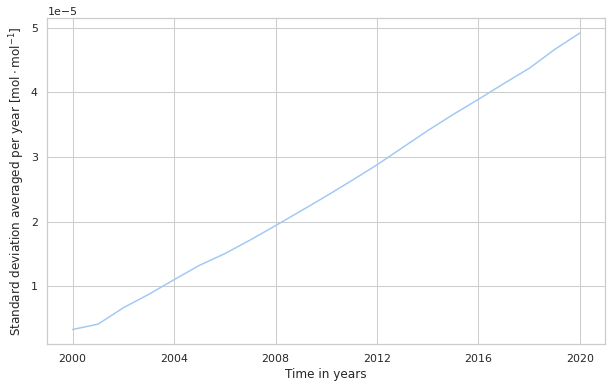

([<matplotlib.axis.XTick at 0x15054338fc70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

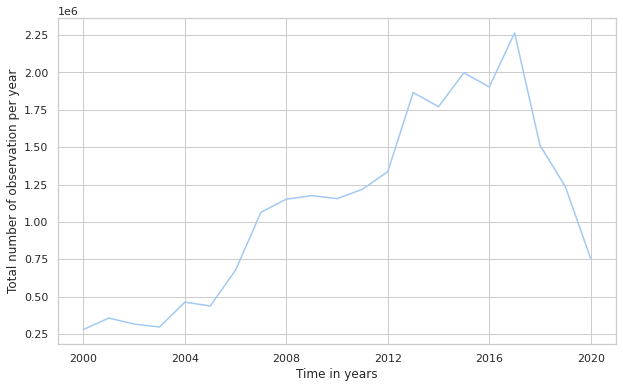

In [12]:
df_GCP.groupby(df_GCP.index.get_level_values('time').year).stddev.mean().plot()
plt.ylabel(r'Standard deviation averaged per year [$\mathrm{mol\cdot mol^{-1}}$]')
plt.xlabel('Time in years')
plt.xticks(range(2000,2021, 4))
plt.show()
df_GCP.groupby(df_GCP.index.get_level_values('time').year).size().plot()
plt.ylabel(r'Total number of observation per year')
plt.xlabel('Time in years')
plt.xticks(range(2000,2021, 4))

In [13]:
def evaluate_site(raw_dat, site, measures, cont_sf = None):
    site_dat = raw_dat.xs(site, level=1)
    sim = site_dat['simulated']
    obs = site_dat['observed']

    measure_dict = {}
    for measure in measures:
        if measure == 'location':
            value = site_dat.geometry[0]
        if measure == 'continent':
            if cont_sf.empty:
                raise RuntimeError('No continent file has been passed down to the "evaluate_site" function')
            point = site_dat.geometry[0]    
            value = get_continent(point, cont_sf, site)
        if measure == 'N':
            value = len(site_dat)
        if measure == 'error':
            value = get_error(sim, obs)
        if measure == 'mse':
            value = get_mse(sim,obs)
        if measure == 'rmse':
            value = get_rmse(sim,obs)
        if measure == 'index_of_agreement':
            value = get_index_of_agreement(sim,obs)
        if measure == 'correlation':
            value = get_correlation(sim, obs)
        if measure == 'ame':
            value = get_ame(sim, obs)
        if measure == 'mae':
            value = get_mae(sim, obs)
        if measure == 'me':
            value = get_me(sim, obs)
        if measure == 'bias':
            value = get_bias(sim, obs)
        if measure == 'abs_bias':
            value = get_abs_bias(sim, obs)
        if measure == 'taylor':
            value = get_taylor(sim, obs)
        measure_dict[measure] = value
    
    return measure_dict



def get_continent(point, continent_sf, site): 
    if ((point.x > 180) or (point.x<-180)) or ((point.y > 90) or (point.y<-90)):
        print(f'------ site {site} is out of bounds, dubble check location {point}')
        return 'Out of bounds'
    for i in continent_sf.index:
        if point.within(continent_sf.loc[i].geometry):
            return i
        
    print(f'----------No region for site {site} been found: Check wether point {point} is within the ocean')
    return 'Seven seas (open ocean)'


In [202]:
df.xs('CHR', level=1).geometry[0]

TypeError: Index must be a MultiIndex

In [14]:
runs = {'optimized', 'smoothed', 'monthly', 'prior'}
# sites = {'lut', 'smr', 'pal', 'mhd'}
measures = ['N','rmse', 'me', 'abs_bias','location', 'continent']

sf = gpd.read_file(continents_file)
indeces = list(range(0,11))+ [22]
sf = sf.iloc[indeces]

continents = sf[['transcom_n', 'geometry']].dissolve(by='transcom_n', sort=False)
print(continents)


                                                                   geometry
transcom_n                                                                 
North American Boreal     MULTIPOLYGON (((-161.00000 56.00000, -160.0000...
North American Temperate  MULTIPOLYGON (((-110.00000 23.00000, -110.0000...
South American Tropical   MULTIPOLYGON (((-68.00000 11.00000, -68.00000 ...
South American Temperate  MULTIPOLYGON (((-60.00000 -52.00000, -60.00000...
Northern Africa           POLYGON ((42.00000 0.00000, 41.00000 0.00000, ...
Southern Africa           MULTIPOLYGON (((49.00000 -21.00000, 48.00000 -...
Eurasia Boreal            MULTIPOLYGON (((155.00000 50.00000, 155.00000 ...
Eurasia Temperate         MULTIPOLYGON (((81.00000 8.00000, 82.00000 8.0...
Tropical Asia             MULTIPOLYGON (((116.00000 -8.00000, 123.00000 ...
Australia                 MULTIPOLYGON (((174.00000 -42.00000, 174.00000...
Europe                    MULTIPOLYGON (((-6.00000 54.00000, -6.00000 52...
Not optimize

In [15]:
files_optimized = [MAIN_DIR+'optimized/'+f for f in common_files]
for f in files_optimized:
    with xr.open_dataset(f) as ds:
        print(ds.site_code)
        if ds.site_code == 'HFM': 
            stop_time = ds.dataset_stop_date.split(':')[0]
            print(f'{ds.site_code} --> stops at {stop_time} vs final_time {ds.time.values[-1]}')

#         print(f'site {ds.site_code} stops at {stop_time} vs {final_time}')

BMW
HUN
SMO
CMA
STR
SVB
TOH
IPR
SMR
LEF
SMO
SGP
TGC
WKT
AMT
MID
SCT
SMR
TOH
KIT
SNP
LUT
GAT
BHD
WKT
HUN
DSI
LMP
SHM
WKT
SGP
ZEP
MWO
BSD
SPO
OXK
SCA
KIT
KIT
NWR
CRV
WBI
PUY
SMR
HUN
SPO
KIT
SUM
SUM
WKT
OXK
NAT
RGL
LIN
GAT
HTM
WGC
LIN
HPB
ZEP
ESP
PAL
CPT
AMT
GAT
RPB
IPR
DRP
UUM
BIR
CPS
ENA
CFA
CRV
HNP
USH
ASK
UTA
CRV
GCI02
GCI05
TRN
INU
HTM
SAC
KRE
LEF
OPE
CAR
SYO
BHD
SPO
BRA
BHD
ZEP
HPB
BRW
CRZ
KRE
SNP
OXK
OMP
WLG
MLO
OXK
BRW
TRN
NWR
RUN
CIB
ETL
KRE
ABT
BMW
LEW
HUN
LMP
MRC
AMY
NAT
SVB
WBI
AOA
CPT
RTA
CHR
AMT
ALT
MLO
LEF
STE
TAC
TAP
KIT
WBI
AMT
MWO
MAA
SNP
SAC
SNP
IZO
SCT
KEY
WBI
OXK
SVB
OPE
EGB
HFM
HFM --> stops at 2019-12-31T23 vs final_time 2019-12-31T23:30:00.000000000
GMI
MLO
TAC
AMY
SPO
MHD
CBY
SVB
LEW
SVB
LEF
OPE
ICE
WGC
STE
BLK
CHL
BKT
JFJ
SMO
OXK
LIN
GAT
EIC
OXK
FSD
GAT
WBI
KIT
CAR
SMR
LEF
TOH
LLN
TRN
IPR
CRV
UTO
CGO
LMP
PFA
SPO
ACT
TOH
JFJ
CRV
IPR
SGP
USH
TPD
SYO
IPR
SMO
CVO
HPB
ESP
COP
HUN
PAL
IAGOS
NWR
SCT
OLI
CMA
KUM
RK1
OSI
FNE
BHD
MBO
SMR
NHA
WIS
DRP
LEF
TOH
KRE
PAL
PFA
PUY

In [16]:
# for site in sites:
#     print(f'Site {site} present in all runs?: {site in common_sites}')

# set_of_sites = sites.intersection(common_sites) # filter out the sites that are not present in all runs

# simply taking all common sites:
set_of_sites = set([x.split('_')[1] for x in common_files])
set_of_sites = {x.upper() for x in set_of_sites}

print(f'Analysing the sites {set_of_sites}\n')



dfs = []
for run in runs:
    raw_dat = get_cte(run, files=common_files) # , sites=set_of_sites)
    data_dict = {}
    for site in set_of_sites:
        site = site.split('-')[0]
        performance_dict = evaluate_site(raw_dat, site, measures, cont_sf=continents)
        print(measures)
        #print(performance_dict)
        data_dict[site] = list(performance_dict.values())
    df = pd.DataFrame.from_dict(data_dict, orient='index', columns=measures)
    df['run'] = run
    dfs.append(df)
    print(df)
data = pd.concat(dfs)
cols = data.columns.tolist()
cols = cols[-2:] + cols[:-2]
data = data[cols].sort_index()
print(data)
save_file = SAVE_DIR + 'run_evaluation.pkl'
data.to_pickle(save_file)

Analysing the sites {'WKT', 'ENA', 'MWO', 'CMA', 'OPE', 'USH', 'CIB', 'DSI', 'HTM', 'COP', 'STR', 'YON', 'LLN', 'LMP', 'INU', 'KCMP', 'RPB', 'AMS', 'CHR', 'CMN', 'CPT', 'CYA', 'FSD', 'DEC', 'GMI', 'UTA', 'RUN', 'NWR', 'MID', 'ICE', 'MRC', 'SMO', 'WSA', 'HBA', 'GPA', 'BCK', 'TOH', 'HIL', 'RYO', 'CHL', 'PFA', 'JFJ', 'LEW', 'IAGOS-CARIBIC', 'SUM', 'SGP', 'TPD', 'IZO', 'PUY', 'MBO', 'HFM', 'SCA', 'SNP', 'LEF', 'SPO', 'ABT', 'EIC', 'WGC', 'BSD', 'OSI', 'GCI05', 'MLO', 'WSD', 'CAR', 'RTA', 'SCT', 'CGO', 'STE', 'KEY', 'WBI', 'FNE', 'LLB', 'MNM', 'MQA', 'CPS', 'BMW', 'CRZ', 'NAT', 'IPR', 'KIT', 'ETL', 'NHA', 'RGL', 'WIS', 'MSH', 'BLK', 'AOA', 'BHD', 'EST', 'BKT', 'LUT', 'PAL', 'OMP', 'CBA', 'MAA', 'SVB', 'HNP', 'UUM', 'ZEP', 'AMY', 'LJO', 'CRV', 'SMR', 'HUN', 'WLG', 'OLI', 'NMB', 'DRP', 'ALT', 'KRE', 'CBY', 'BRA', 'AMT', 'RK1', 'MHD', 'MEX', 'TAP', 'TAC', 'ESP', 'UTO', 'EGB', 'BRW', 'GAT', 'TGC', 'WAO', 'SAC', 'KUM', 'THD', 'PSA', 'OXK', 'LMU', 'AZR', 'SEY', 'TRN', 'ASC', 'CVO', 'NOR', 'HPB', 

/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_ena_surface-insitu_64_allvalid-10magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_cfa_surface-flask_2_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_crv_tower-insitu_1_allvalid-32magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_hnp_surface-insitu_6_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_ush_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_ask_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_uta_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_crv_tower-insitu_1_allvalid-17magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_gci02_tower-insitu_60_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_gci05_tower-insitu_60_allvalid.nc
/projects/0/ctdas/

/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_mhd_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_cby_surface-insitu_6_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_svb_surface-insitu_442_allvalid-85magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_lew_surface-pfp_1_allvalid-95magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_svb_surface-insitu_442_allvalid-35magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_lef_aircraft-pfp_1_allvalid-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_ope_surface-insitu_442_allvalid-120magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_ice_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_wgc_tower-insitu_1_allvalid-91magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_ste_surface-insitu_442_allvalid-32magl

/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_etl_aircraft-pfp_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_ope_surface-insitu_442_allvalid-50magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_act_aircraft-insitu_428_allvalid-c130.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_lin_surface-insitu_442_allvalid-10magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_cmn_surface-insitu_442_allvalid-8magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_chr_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_smo_surface-insitu_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_htm_surface-insitu_442_allvalid-150magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_zep_surface-insitu_442_allvalid-15magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_sac_surface-insitu_442_allvalid

/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_sac_surface-insitu_442_allvalid-50magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_wbi_surface-pfp_1_allvalid-379magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_etl_aircraft-pfp_1_allvalid-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_htm_surface-insitu_442_allvalid-150magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_mex_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_wsd_tower-insitu_60_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_lin_surface-insitu_442_allvalid-98magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_cib_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_lef_tower-insitu_1_allvalid-396magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_snp_surface-insitu_1_allvalid-17magl.nc
/

/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_amt_tower-insitu_1_allvalid-12magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_mbo_surface-insitu_1_allvalid-11magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_msh_surface-pfp_1_allvalid-46magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_sct_surface-pfp_1_allvalid-305magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_nor_surface-insitu_442_allvalid-100magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_mhd_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_wgc_surface-pfp_1_allvalid-91magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_kre_surface-insitu_442_allvalid-10magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_hba_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/prior/co2_htm_surface-insitu_442_al

['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site MNM been found: Check wether point POINT (153.98 24.28) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site MQA been found: Check wether point POINT (158.967 -54.483) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site BMW been found: Check wether point POINT (-64.8788 32.2647) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site CRZ been found: Check wether point POINT (51.8478 -46.4337) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']

/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_str_surface-pfp_1_allvalid-232magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_svb_surface-insitu_442_allvalid-150magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_toh_surface-insitu_442_allvalid-147magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_ipr_surface-insitu_442_allvalid-100magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_smr_surface-insitu_442_allvalid-125magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_lef_aircraft-pfp_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_smo_surface-flask_426_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_sgp_aircraft-pfp_1_allvalid-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_tgc_aircraft-pfp_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_wkt_tower-i

/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_kre_surface-insitu_442_allvalid-50magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_lef_tower-insitu_1_allvalid-30magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_ope_surface-insitu_442_allvalid-10magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_car_aircraft-pfp_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_syo_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_bhd_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_spo_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_bra_surface-insitu_6_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_bhd_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_zep_surface-flas

/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_chl_surface-insitu_6_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_bkt_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_jfj_surface-insitu_5_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_smo_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_oxk_surface-insitu_442_allvalid-90magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_lin_surface-insitu_442_allvalid-2.5magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_gat_surface-insitu_442_allvalid-132magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_eic_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_oxk_surface-insitu_442_allvalid-23magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_fsd_

/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_sac_surface-insitu_442_allvalid-15magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_kcmp_tower-insitu_102_allhours-200magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_izo_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_wlg_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_uum_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_smr_surface-insitu_442_allvalid-67magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_hpb_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_sct_tower-insitu_1_allvalid-61magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_gmi_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_azr_surf

/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_cib_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_lef_tower-insitu_1_allvalid-396magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_snp_surface-insitu_1_allvalid-17magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_wbi_tower-insitu_1_allvalid-379magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_kre_surface-insitu_442_allvalid-250magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_ice_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_nor_surface-insitu_442_allvalid-58magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_gat_surface-insitu_442_allvalid-30magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_mbo_surface-insitu_1_allvalid-11magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/c

/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_kre_surface-insitu_442_allvalid-10magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_hba_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_htm_surface-insitu_442_allvalid-30magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_wgc_surface-pfp_1_allvalid-91magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_act_aircraft-insitu_428_allvalid-b200.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_nor_surface-insitu_442_allvalid-100magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_wis_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_nwr_surface-pfp_1_allvalid-3magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_tgc_aircraft-pfp_1_allvalid-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/smoothed/co2_hil_ai

----------No region for site AZR been found: Check wether point POINT (-27.375 38.766) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site SEY been found: Check wether point POINT (55.5325 -4.6824) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site ASC been found: Check wether point POINT (-14.4 -7.9667) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site CVO been found: Check wether point POINT (-24.8675 16.864) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
------ site ACT is out of bounds, dubble check location POINT (-10000000000000000000000000000000000 -10000000000000

/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_oxk_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_nat_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_rgl_tower-insitu_160_allvalid-90magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_lin_surface-insitu_442_allvalid-40magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_gat_surface-insitu_442_allvalid-341magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_htm_surface-insitu_442_allvalid-70magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_wgc_tower-insitu_1_allvalid-483magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_lin_surface-insitu_442_allvalid-10magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_hpb_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/

/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_lef_tower-insitu_1_allvalid-122magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_ste_surface-insitu_442_allvalid-127magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_tac_tower-insitu_160_allvalid-54magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_tap_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_kit_surface-insitu_442_allvalid-200magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_wbi_tower-insitu_1_allvalid-379magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_amt_tower-insitu_1_allvalid-30magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_mwo_surface-pfp_1_allvalid-46magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_maa_surface-flask_2_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/opt

/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_pal_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_iagos-caribic_aircraft-insitu_457_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_nwr_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_sct_tower-insitu_1_allvalid-31magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_oli_surface-insitu_64_allvalid-10magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_cma_aircraft-pfp_1_allvalid-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_kum_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_rk1_surface-flask_426_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_osi_tower-insitu_68_allhours-31magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized

/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_sca_aircraft-pfp_1_allvalid-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_trn_surface-insitu_442_allvalid-100magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_osi_tower-insitu_68_allhours-269magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_alt_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_gat_surface-insitu_442_allvalid-132magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_toh_surface-insitu_442_allvalid-10magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_sct_tower-insitu_1_allvalid-61magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_brw_surface-flask_426_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_ste_surface-insitu_442_allvalid-32magl.nc
/projects/0/ctdas/awoude/Ritten/transport_resul

/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_nmb_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_rpb_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_uto_surface-insitu_442_allvalid-57magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_sac_surface-insitu_442_allvalid-100magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_amt_surface-pfp_1_allvalid-107magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_trn_surface-insitu_442_allvalid-50magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_mrc_surface-pfp_1_allvalid-61magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_gat_surface-insitu_442_allvalid-341magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/optimized/co2_wbi_tower-insitu_1_allvalid-31magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/opt

['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site MNM been found: Check wether point POINT (153.98 24.28) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site MQA been found: Check wether point POINT (158.967 -54.483) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site BMW been found: Check wether point POINT (-64.8788 32.2647) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site CRZ been found: Check wether point POINT (51.8478 -46.4337) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']

/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_cma_aircraft-pfp_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_str_surface-pfp_1_allvalid-232magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_svb_surface-insitu_442_allvalid-150magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_toh_surface-insitu_442_allvalid-147magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_ipr_surface-insitu_442_allvalid-100magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_smr_surface-insitu_442_allvalid-125magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_lef_aircraft-pfp_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_smo_surface-flask_426_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_sgp_aircraft-pfp_1_allvalid-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_tgc_aircraft-pfp_1_al

/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_kre_surface-insitu_442_allvalid-50magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_lef_tower-insitu_1_allvalid-30magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_ope_surface-insitu_442_allvalid-10magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_car_aircraft-pfp_1_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_syo_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_bhd_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_spo_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_bra_surface-insitu_6_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_bhd_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_zep_surface-flask_1_repres

/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_chl_surface-insitu_6_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_bkt_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_jfj_surface-insitu_5_allvalid.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_smo_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_oxk_surface-insitu_442_allvalid-90magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_lin_surface-insitu_442_allvalid-2.5magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_gat_surface-insitu_442_allvalid-132magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_eic_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_oxk_surface-insitu_442_allvalid-23magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_fsd_surface-in

/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_izo_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_wlg_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_uum_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_smr_surface-insitu_442_allvalid-67magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_hpb_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_sct_tower-insitu_1_allvalid-61magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_gmi_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_azr_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_ste_surface-insitu_442_allvalid-252magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_wao_surface-insitu_13

/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_snp_surface-insitu_1_allvalid-17magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_wbi_tower-insitu_1_allvalid-379magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_kre_surface-insitu_442_allvalid-250magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_ice_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_nor_surface-insitu_442_allvalid-58magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_gat_surface-insitu_442_allvalid-30magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_mbo_surface-insitu_1_allvalid-11magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_crv_tower-insitu_1_allvalid-32magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_msh_surface-pfp_1_allvalid-46magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_rta_a

/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_kre_surface-insitu_442_allvalid-10magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_hba_surface-flask_1_representative-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_htm_surface-insitu_442_allvalid-30magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_wgc_surface-pfp_1_allvalid-91magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_act_aircraft-insitu_428_allvalid-b200.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_nor_surface-insitu_442_allvalid-100magl.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_wis_surface-flask_1_representative.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_nwr_surface-pfp_1_allvalid-3magl-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_tgc_aircraft-pfp_1_allvalid-NRT.nc
/projects/0/ctdas/awoude/Ritten/transport_results/monthly/co2_hil_aircraft-pfp

----------No region for site PSA been found: Check wether point POINT (-64.0527 -64.7742) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site AZR been found: Check wether point POINT (-27.375 38.766) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site SEY been found: Check wether point POINT (55.5325 -4.6824) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site ASC been found: Check wether point POINT (-14.4 -7.9667) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
----------No region for site CVO been found: Check wether point POINT (-24.8675 16.864) is within the ocean
['N', 'rmse', 'me', 'abs_bias', 'location', 'continent']
['N',

In [17]:
print(set(np.unique(raw_dat.index.get_level_values(level=1))).difference(set_of_sites))
print(set_of_sites.difference(set(np.unique(raw_dat.index.get_level_values(level=1)))))


{'IAGOS'}
{'IAGOS-CARIBIC'}


In [18]:
print(data)

                    continent        run     N       rmse        me  abs_bias  \
ABT  North American Temperate      prior   820  12.665291  7.103994  7.419816   
ABT  North American Temperate   smoothed   820  13.615030  5.826581  6.473620   
ABT  North American Temperate    monthly   820   6.027907  1.613787  3.407036   
ABT  North American Temperate  optimized   820  13.130272  3.901350  5.773288   
ACT             Out of bounds      prior     4   4.772467  4.574211  4.574211   
..                        ...        ...   ...        ...       ...       ...   
YON   Seven seas (open ocean)  optimized  4987   2.291008 -0.505296  1.608756   
ZEP   Seven seas (open ocean)    monthly  2797   1.326189  0.249892  0.803720   
ZEP   Seven seas (open ocean)   smoothed  2797   2.180865  1.513938  1.756797   
ZEP   Seven seas (open ocean)  optimized  2797   1.371511  0.256178  0.806724   
ZEP   Seven seas (open ocean)      prior  2797   4.058110  3.512504  3.584548   

                           

In [62]:
idx = pd.IndexSlice

sites = set([i[1] for i in raw_dat.index])

for sit in sites:
    print(f'site {sit} is in set_of_sites?: {(sit in set_of_sites)}')
#print(set_of_sites.intersection({'HUN'}))
#raw_dat.index[:][1]#.loc[:,idx[:,'name']]

{'HUN'}
site TOH is in set_of_sites?: True
site TAP is in set_of_sites?: True
site SNP is in set_of_sites?: True
site FNE is in set_of_sites?: True
site BCK is in set_of_sites?: True
site ESP is in set_of_sites?: True
site SCA is in set_of_sites?: True
site YON is in set_of_sites?: True
site MHD is in set_of_sites?: True
site BSD is in set_of_sites?: True
site STE is in set_of_sites?: True
site WBI is in set_of_sites?: True
site MSH is in set_of_sites?: True
site JFJ is in set_of_sites?: True
site PFA is in set_of_sites?: True
site CHL is in set_of_sites?: True
site DRP is in set_of_sites?: True
site KRE is in set_of_sites?: True
site MID is in set_of_sites?: True
site BHD is in set_of_sites?: True
site NHA is in set_of_sites?: True
site LJO is in set_of_sites?: True
site WSA is in set_of_sites?: True
site AMY is in set_of_sites?: True
site SVB is in set_of_sites?: True
site HFM is in set_of_sites?: True
site GCI02 is in set_of_sites?: True
site MAA is in set_of_sites?: True
site TRN i

In [19]:
save_file = SAVE_DIR + 'run_evaluation.pkl'
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# pd.reset_option('all')

df = pd.read_pickle(save_file)
csv_file = SAVE_DIR + 'run_evaluation.csv'
df.to_csv(csv_file)

In [20]:
print(df[['continent','run','N','rmse', 'me']].to_string())

                      continent        run      N       rmse         me
ABT    North American Temperate      prior    820  12.665291   7.103994
ABT    North American Temperate   smoothed    820  13.615030   5.826581
ABT    North American Temperate    monthly    820   6.027907   1.613787
ABT    North American Temperate  optimized    820  13.130272   3.901350
ACT               Out of bounds      prior      4   4.772467   4.574211
ACT               Out of bounds    monthly      4   3.030595   2.502205
ACT               Out of bounds   smoothed      4   3.829295   3.401100
ACT               Out of bounds  optimized      4   4.214449   2.895996
ALT       North American Boreal  optimized   1342   0.586343  -0.144311
ALT       North American Boreal    monthly   1342   0.729836  -0.060655
ALT       North American Boreal      prior   1342   3.819542   3.505944
ALT       North American Boreal   smoothed   1342   1.608685   1.348225
AMS     Seven seas (open ocean)      prior   1311   1.075309   0

In [27]:
len(np.unique(df.index))

147

In [21]:
invalid_stations = []
for station in np.unique(df.index):
    if len(np.unique(df.loc[station].N))>1: # This would mean a staion does not have the same number of observations per run
        print(df.loc[station])
        invalid_stations.append(station)
print(f'total list of invalid stations: {invalid_stations}')

total list of invalid stations: []


continent          run     N       rmse        me  \
ABT  North American Temperate  monthly_avg   820   6.027907  1.613787   
ABT  North American Temperate      CTE2018   820  13.615030  5.826581   
ABT  North American Temperate      GCPsib4   820  13.110088  4.019014   
ACT             Out of bounds  monthly_avg     4   3.030595  2.502205   
ACT             Out of bounds      CTE2018     4   3.829295  3.401100   
..                        ...          ...   ...        ...       ...   
YON   Seven seas (open ocean)      CTE2018  4987   2.207376  0.184546   
YON   Seven seas (open ocean)      GCPsib4  4987   2.255234 -0.327850   
ZEP   Seven seas (open ocean)  monthly_avg  2797   1.326189  0.249892   
ZEP   Seven seas (open ocean)      CTE2018  2797   2.180865  1.513939   
ZEP   Seven seas (open ocean)      GCPsib4  2797   1.408244  0.417992   

     abs_bias                                           location  
ABT  3.407036                          POINT (-122.3353 49.0114)  
ABT  6.473620                          POINT (-122.3353 49.0114)  
ABT  5.797036                          POINT (-122.3353 49.0114)  
ACT  2.502205  POINT (-10000000000000000000000000000000000 -1...  
ACT  3.401100  POINT (-10000000000000000000000000000000000 -1...  
..        ...                                                ...  
YON  1.615787                               POINT (123.02 24.47)  
YON  1.587491                               POINT (123.02 24.47)  
ZEP  0.803720                            POINT (11.8883 78.9067)  
ZEP  1.756797                            POINT (11.8883 78.9067)  
ZEP  0.857715                            POINT (11.8883 78.9067)  

[438 rows x 7 columns]

N
run                
CTE2018      608659
GCPsib4      608659
monthly_avg  608659

In [22]:
df[['N', 'run']].groupby(['run']).sum().N[3]

617090

/scratch-local/awoude/ipykernel_3081046/2903706081.py:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  figs = df.boxplot(ax=ax, by =['run'],


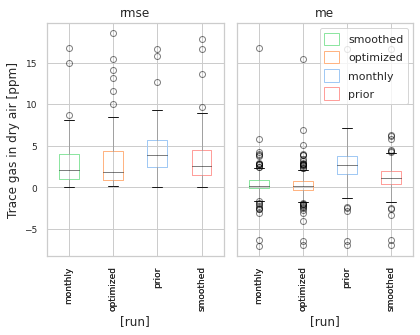

N=147
total number of observations: 
run
monthly      617090
optimized    617090
prior        617090
smoothed     617090
Name: N, dtype: int64
average ME: 
run
monthly      0.412324
optimized    0.342779
prior        2.651622
smoothed     1.272908
Name: me, dtype: float32
average RMSE: 
run
monthly      2.855059
optimized    3.131132
prior        4.274340
smoothed     3.398294
Name: rmse, dtype: float32


In [23]:
save_file = SAVE_DIR + 'run_evaluation.pkl'
df = pd.read_pickle(save_file)
df = df[~df.index.isin(invalid_stations)] # Remove all invalid stations

fig, ax = plt.subplots(figsize=(6,5))

# for meas in measures:
#     if meas != 'N' and meas != 'continent' and meas != 'location':
#         df[meas] /= 1e6
figs = df.boxplot(ax=ax, by =['run'], 
                                            column =['rmse', 'me'],
                                            grid = True, 
                                            rot = 90,
#                                             positions = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 19, 
#                                                          21, 22, 24, 25, 27, 28],
#                                             positions = [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 22,
#                                                          23, 24, 25, 27, 28, 29, 31, 32, 33, 35, 36, 37],
                                            fontsize = 9,
                                            return_type='both'
                                             )

figs[0].ax.set_ylabel('Trace gas in dry air [ppm]')



colors = ['C02', 'C01', 'C00', 'C03']
for bplot in figs:
    for patch, color in zip(bplot.lines['boxes'], colors*12):
        patch.set_color(color)
        patch.set_linewidth(1)
    for patch, color in zip(bplot.lines['fliers'], colors*12):
        patch.set_alpha(0.5) 
    for line in bplot.lines['medians']:
        line.set_color('black')
        line.set_alpha(0.5)
        
smoothed_patch = Rectangle((0,0),10,10,
                    edgecolor=colors[0],
                    facecolor='none',
                    lw=1,
                    label = 'smoothed')
optimized_patch = Rectangle((0,0),10,10,
                    edgecolor=colors[1],
                    facecolor='none',
                    lw=1,
                    label = 'optimized')
monthly_patch = Rectangle((0,0),10,10,
                    edgecolor=colors[2],
                    facecolor='none',
                    lw=1,
                    label = 'monthly')
prior_patch = Rectangle((0,0),10,10,
                    edgecolor=colors[3],
                    facecolor='none',
                    lw=1,
                    label = 'prior')
plt.legend(handles=[smoothed_patch, optimized_patch, monthly_patch, prior_patch], handlelength=1.4, handleheight=1.4)
figs[0].ax.get_figure().suptitle('')
plt.tight_layout()
plt.show()

print(f'N={len(np.unique(df.index))}')
print(f"total number of observations: \n{df[['N', 'run']].groupby(['run']).sum().N}")
print(f"average ME: \n{df[['me', 'run']].groupby(['run']).mean().me}")
print(f"average RMSE: \n{df[['rmse', 'run']].groupby(['run']).mean().rmse}")

In [24]:
df_gb = df.groupby(['run', 'continent'])
print(df_gb.size())
print(df_gb.sum().N)
#for df_gb.groups.items()

run        continent               
monthly    Australia                    2
           Eurasia Temperate            6
           Europe                      31
           North American Boreal       14
           North American Temperate    35
           Northern Africa              2
           Not optimized                4
           Out of bounds                3
           Seven seas (open ocean)     45
           South American Temperate     2
           Southern Africa              1
           Tropical Asia                2
optimized  Australia                    2
           Eurasia Temperate            6
           Europe                      31
           North American Boreal       14
           North American Temperate    35
           Northern Africa              2
           Not optimized                4
           Out of bounds                3
           Seven seas (open ocean)     45
           South American Temperate     2
           Southern Africa              

[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58]


/scratch-local/awoude/ipykernel_3081046/72136464.py:13: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  figs = df.boxplot(ax=ax, by =['continent', 'run'],


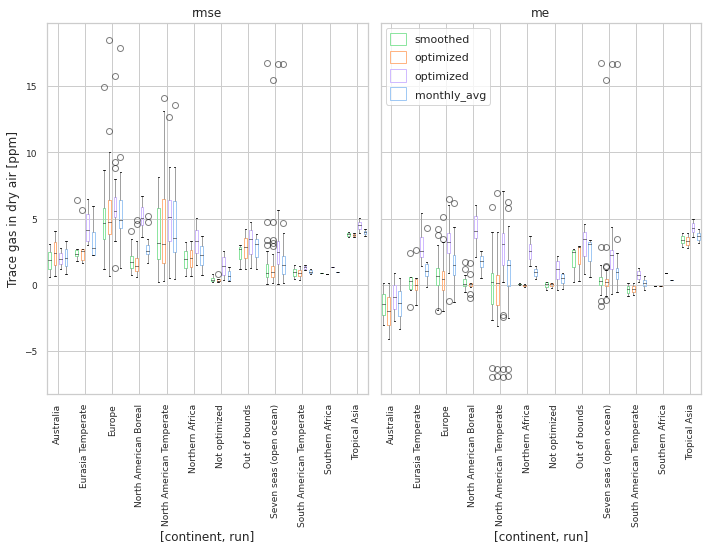

run        continent               
monthly    Australia                    2
           Eurasia Temperate            6
           Europe                      31
           North American Boreal       14
           North American Temperate    35
           Northern Africa              2
           Not optimized                4
           Out of bounds                3
           Seven seas (open ocean)     45
           South American Temperate     2
           Southern Africa              1
           Tropical Asia                2
optimized  Australia                    2
           Eurasia Temperate            6
           Europe                      31
           North American Boreal       14
           North American Temperate    35
           Northern Africa              2
           Not optimized                4
           Out of bounds                3
           Seven seas (open ocean)     45
           South American Temperate     2
           Southern Africa              

In [25]:
save_file = SAVE_DIR + 'run_evaluation.pkl'
df = pd.read_pickle(save_file)
df = df[~df.index.isin(invalid_stations)] # remove all invalid stations

fig, ax = plt.subplots(figsize=(10,8))

# for meas in measures:
#     if meas != 'N' and meas != 'continent' and meas != 'location':
#         df[meas] /= 1e6
pos = [[(i*5)+j for j in range(4)] for i in range(12)]
pos = sum(pos, [])
print(pos)
figs = df.boxplot(ax=ax, by =['continent', 'run'], 
                                            column =['rmse', 'me'],
                                            grid = True, 
                                            rot = 90,
#                                             positions = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 19, 
#                                                          21, 22, 24, 25, 27, 28],
                                            positions = pos,
                                            fontsize = 9,
                                            return_type='both'
                                             )
# ax = df.boxplot(by =['run','continent'], column =['rmse', 'me'], grid = True)[0]
figs[0].ax.set_ylabel('Trace gas in dry air [ppm]')


colors = ['C02', 'C01','C04', 'C00']
df_cont = df[['continent', 'N']].groupby(['continent'])
continents = list(df_cont.groups.keys())
plt.xticks(np.arange(1.5, len(continents) * 5+1.5, 5), continents)

for bplot in figs:
    for patch, color in zip(bplot.lines['boxes'], colors*12):
        patch.set_color(color)
        patch.set_linewidth(1)
    for patch, color in zip(bplot.lines['fliers'], colors*12):
        patch.set_alpha(0.5) 
    for line in bplot.lines['medians']:
        line.set_color('black')
        line.set_alpha(0.5)
        
smoothed_patch = Rectangle((0,0),10,10,
                    edgecolor=colors[0],
                    facecolor='none',
                    lw=1,
                    label = 'smoothed')
optimized_patch = Rectangle((0,0),10,10,
                    edgecolor=colors[1],
                    facecolor='none',
                    lw=1,
                    label = 'optimized')
optimized_val_patch = Rectangle((0,0),10,10,
                    edgecolor=colors[2],
                    facecolor='none',
                    lw=1,
                    label = 'optimized')
monthly_patch = Rectangle((0,0),10,10,
                    edgecolor=colors[3],
                    facecolor='none',
                    lw=1,
                    label = 'monthly_avg')
#ax.legend([figs[0]["boxes"][0], figs[1]["boxes"][0]], ["Box Plot 1", "Box Plot 2"], loc='upper right')

plt.legend(handles=[smoothed_patch, optimized_patch, optimized_val_patch, monthly_patch], handlelength=1.4, handleheight=1.4)
figs[0].ax.get_figure().suptitle('')
plt.tight_layout()
plt.show()
df_gb = df[['run', 'continent', 'N']].groupby(['run', 'continent'])
print(df_gb.size())
print(df_gb.sum().N)

In [136]:
len(continents)

12

In [129]:
df_gb = df[['continent', 'N']].groupby(['continent'])
list(df_gb.groups.keys())

['Australia',
 'Eurasia Temperate',
 'Europe',
 'North American Boreal',
 'North American Temperate',
 'Northern Africa',
 'Not optimized',
 'Out of bounds',
 'Seven seas (open ocean)',
 'South American Temperate',
 'Southern Africa',
 'Tropical Asia']

In [44]:
print(figs[1].lines['fliers'])

[]


In [17]:
def centroid(vertexes):
     x_list = [vertex [0] for vertex in vertexes]
     y_list = [vertex [1] for vertex in vertexes]
     length = len(vertexes)
     x = sum(x_list) / length
     y = sum(y_list) / length
     return(x, y)

sf = gpd.read_file(continents_file)
indeces = list(range(0,11))+ [22]
sf = sf.iloc[indeces]

continents = sf[['transcom_n', 'geometry']].dissolve(by='transcom_n', sort=False)
polygons = continents['geometry']

continents

geometry
transcom_n                                                                 
North American Boreal     MULTIPOLYGON (((-161.00000 56.00000, -160.0000...
North American Temperate  MULTIPOLYGON (((-110.00000 23.00000, -110.0000...
South American Tropical   MULTIPOLYGON (((-68.00000 11.00000, -68.00000 ...
South American Temperate  MULTIPOLYGON (((-60.00000 -52.00000, -60.00000...
Northern Africa           POLYGON ((42.00000 0.00000, 41.00000 0.00000, ...
Southern Africa           MULTIPOLYGON (((49.00000 -21.00000, 48.00000 -...
Eurasia Boreal            MULTIPOLYGON (((155.00000 50.00000, 155.00000 ...
Eurasia Temperate         MULTIPOLYGON (((81.00000 8.00000, 82.00000 8.0...
Tropical Asia             MULTIPOLYGON (((116.00000 -8.00000, 123.00000 ...
Australia                 MULTIPOLYGON (((174.00000 -42.00000, 174.00000...
Europe                    MULTIPOLYGON (((-6.00000 54.00000, -6.00000 52...
Not optimized             MULTIPOLYGON (((-61.00000 -67.00000, -60.00000...

In [20]:
#df.geometry
# print(type(continents.geometry.centroid))
# shape_earth.contains(df.geometry[0])
shape_earth = Polygon([(-180, 90), (-180, -90), (180, -90), (180, 90)])
print(len(gpd.GeoSeries(df.geometry).within(shape_earth).values))
print(df)
print(df.where(gpd.GeoSeries(df.geometry).within(shape_earth)))
# #print(continents.geometry[0])
# print(continents.geometry.centroid[0])
# continents.geometry.centroid.within(shape_earth)
# #pointInPolys = gpd.tools.sjoin(continents, shape_earth, op="within", how='left')

AttributeError: 'DataFrame' object has no attribute 'geometry'

/scratch-local/awoude/ipykernel_545679/4003506296.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x,y,label in zip (continents.geometry.centroid.x, continents.geometry.centroid.y, continents.index):
/scratch-local/awoude/ipykernel_545679/4003506296.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x,y,label in zip (continents.geometry.centroid.x, continents.geometry.centroid.y, continents.index):


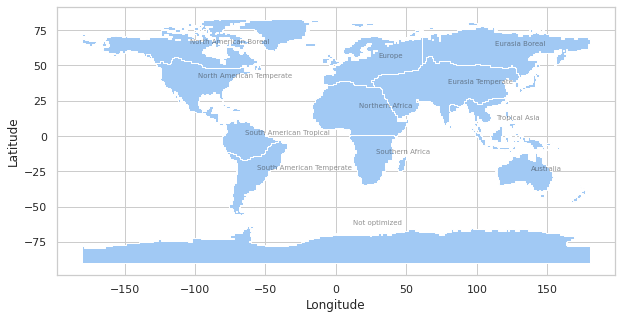

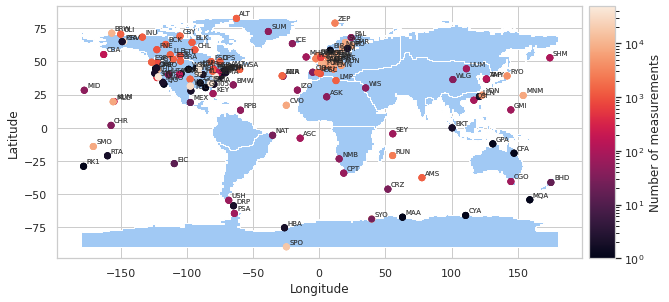

In [21]:
save_file = SAVE_DIR + 'run_evaluation.pkl'
df = pd.read_pickle(save_file)

df = df.rename(columns ={'location':'geometry'})

shape_earth = Polygon([(-180, 90), (-180, -90), (180, -90), (180, 90)])
df = df.where(gpd.GeoSeries(df.geometry).within(shape_earth))

fig, ax = plt.subplots(figsize=(10,10))

sf = gpd.read_file(continents_file)
indeces = list(range(0,11))+ [22]
sf = sf.iloc[indeces]
continents = sf[['transcom_n', 'geometry']].dissolve(by='transcom_n', sort=False)
#continents = continents[sf.where(continents.geometry.centroid.x <)]
continents.plot(ax=ax)

#centroids = [p.centroid for p in continents['geometry']]
for x,y,label in zip (continents.geometry.centroid.x, continents.geometry.centroid.y, continents.index):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", alpha=0.5, fontsize=7)

ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

plt.show()

fig, ax = plt.subplots(figsize=(10,10))

sf = gpd.read_file(continents_file)
indeces = list(range(0,11))+ [22]
sf = sf.iloc[indeces]

continents = sf[['transcom_n', 'geometry']].dissolve(by='transcom_n', sort=False)
continents.plot(ax=ax)

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)


df = gpd.GeoDataFrame(df)
df.plot(ax=ax, column='N', legend=True, 
        norm=mpl.colors.LogNorm(vmin=df.N.min(), vmax=df.N.max()), 
        cax=cax, legend_kwds={'label': "Number of measurements"})

for x, y, label in zip(df.geometry.x, df.geometry.y, df.index):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", alpha=0.5, fontsize=7)

# for point in df['location']:
#     point.plot(ax=ax)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

plt.show()


In [18]:
continents.index

Index(['Africa', 'Antarctica', 'Asia', 'Europe', 'North America', 'Oceania',
       'Seven seas (open ocean)', 'South America'],
      dtype='object', name='CONTINENT')

In [22]:
sites_upper = {x.upper() for x in sites}

df = get_cte(sites_upper, 'smoothed')

print(df.xs('SMR', level=1))
print(df.xs('LUT', level=1))
print(df.xs('PAL', level=1))
print(df.xs('MHD', level=1))

NameError: name 'sites' is not defined

In [37]:
path = '/scratch-shared/rdkok/4Ritten/smoothed/'
files = sorted(glob(path + '*.nc'))

with xr.open_dataset(files[0]) as ds:
    print(ds.modelsamplesmean)

<xarray.DataArray 'modelsamplesmean' (obs: 37911)>
array([9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36, 9.96921e+36,
       9.96921e+36], dtype=float32)
Dimensions without coordinates: obs
Attributes:
    units:      mol mol-1
    long_name:  mean modelsamples
    comment:    simulated mole fractions based on optimized state vector
